In [1]:
import os
import shutil
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_key = pd.read_excel('KETAMINE_COHORT KEY.xlsx', sheet_name='POST VR5')
df_key.Subject = df_key.Subject.str.upper()

df_data = [pd.read_csv(f) for f in glob.glob('POST-VR5_RESULTS/*/**.csv')]

# if all csvs contain the same level colocization (all doubles, all triples etc)
# then we expect exactly one integer in the following list.
print(np.unique([len(df.columns) for df in df_data]))

# check that all columns match
cols = df_data[0].columns 
all_matches = [np.all(cols == df.columns) for df in df_data]

# if this assertion passes, all cols match for all csvs
assert np.sum(all_matches) == len(df_data)
assert np.all(all_matches) # or this alternatively

# some preprocessing
def preprocessing(coloc_dfs):
    '''
    small fn to automate some of the preprocessing steps that must be done
    on each df before we can concat: removing unncessary whitespaces,
    dropping rows without an intensity measurement
    '''
    # remove leading whitespace from col names
    for df in coloc_dfs:
        df.columns = [col.replace(' ', '') for col in df.columns]

    # drop rows without intensity measurement
    coloc_dfs = [df[~df['mean-background'].isna()] for df in coloc_dfs]

    # remove leading whitespace from filenames (note access via .loc to avoid setting with copy)
    for df in coloc_dfs:
        df.loc[:, 'filename'] = df.filename.str.replace(' ', '')

    return coloc_dfs

df_doubles = preprocessing(df_data)

print(df_doubles[0].columns)
df_doubles[0].head()

[37]
Index(['stain', 'colocw/Parvalbumin', 'colocw/WFA', 'roi_id', 'CoM_x', 'CoM_y',
       'pixel_area', 'background', 'mean_intensity', 'median_intensity',
       'mode_intensity', 'stdev', 'mean-background', 'integrated_density',
       'min', 'max', 'area_legacy', 'mean_legacy', 'integrated_density_legacy',
       'raw_integrated_density', 'CoM_x_legacy', 'CoM_y_legacy', 'min_legacy',
       'max_legacy', 'ferets_diameter', 'feret_x', 'feret_y', 'feret_angle',
       'feret_min', 'circularity', 'aspect_ratio', 'roundness', 'solidity',
       'skewness', 'kurtosis', 'filename', 'analysis_date'],
      dtype='object')


,stain,colocw/Parvalbumin,colocw/WFA,roi_id,CoM_x,CoM_y,pixel_area,background,mean_intensity,median_intensity,...,feret_angle,feret_min,circularity,aspect_ratio,roundness,solidity,skewness,kurtosis,filename,analysis_date
0,Parvalbumin,NaN,0-FFF-00004,0-000-00001,371.51,157.23,236.0,187.042,384.5552,400.1461,...,0.0,14.0,0.9049,1.5642,0.6183,0.9833,-0.1631,-0.3940,KET-8-10F_3.5_D_2.tif,Mon Mar 18 14:13:43 PDT 2024
1,Parvalbumin,-,-,0-000-00004,108.52,503.90,90.0,187.042,148.8522,144.7175,...,0.0,14.0,0.4441,1.2795,0.3517,0.4639,0.9672,1.1283,KET-8-10F_3.5_D_2.tif,Mon Mar 18 14:13:43 PDT 2024
2,Parvalbumin,-,-,0-000-00003,220.23,243.85,245.0,187.042,237.0273,236.5289,...,0.0,16.0,0.9569,1.2369,0.7987,0.9800,0.2275,-0.1545,KET-8-10F_3.5_D_2.tif,Mon Mar 18 14:13:43 PDT 2024
3,Parvalbumin,-,-,0-000-00002,254.08,25.71,321.0,187.042,198.5742,185.3672,...,90.0,20.0,0.7661,1.3061,0.5908,0.7868,0.9405,0.3672,KET-8-10F_3.5_D_2.tif,Mon Mar 18 14:13:43 PDT 2024
4,Parvalbumin,-,-,0-000-00000,495.12,147.14,243.0,187.042,202.6783,187.2926,...,90.0,18.0,0.7696,1.2266,0.6191,0.7993,1.0812,0.9937,KET-8-10F_3.5_D_2.tif,Mon Mar 18 14:13:43 PDT 2024


## Building the necessary cols

In particular we will need a rat_n (sid) col, stain_type col, and a treatment col. the filename col functions as the image name (iid) col.

We need the following cols
- rat_n (sid)
- treatment
- filename (fid)
- imagename (iid)
- stain_type
- CoM_x
- CoM_y
- mean_intensity
- background

In [3]:
def get_ratn(df):
    '''
    '''
    df['rat_n'] = df.filename.apply(lambda x: x.split('_')[0])\
        .replace({' ': ''}, regex=True) # for some reason, we have more leading whitespace chars
    
    def adjust_last_place(s):
        last_substr = s.split('-')[-1]
        last_substr = ''.join([char for char in last_substr if char.isdigit()])

        return '-'.join(s.split('-')[:-1] + [last_substr])
    
    df['rat_n'] = df.rat_n.apply(adjust_last_place)

    
    # some checks. we want be sure that the structure of all our rat_n labels is consistent
    # in particular, we expect something of the form 'PE-12-7', that is we have exactly
    # two dashes '-' separating some letters, followed by two numbers
    assert df.rat_n.apply(lambda x: len(x.split('-')) == 3).sum() == len(df)
    assert df.rat_n.apply(lambda x: x.split('-')[0].isalpha()).sum() == len(df)
    assert df.rat_n.apply(lambda x: x.split('-')[1].isnumeric()).sum() == len(df)
    assert df.rat_n.apply(lambda x: x.split('-')[2].isnumeric()).sum() == len(df)

    return df

def get_treatment(df, treatment):
    '''
    '''
    # creating new treatment col by mapping from cohort key dict
    df['treatment'] = df.rat_n.map(treatment)

    # check that all rat_ns were accounted for
    assert df.treatment.isna().sum() == 0

    return df

    
def get_staintype(df, stains):
    '''
    '''
    # creating new stain_type col from filename
    df['stain_type'] = df.filename.replace(stains, regex=True)
    
    # check that all filenames were accounted for
    assert df.stain_type.isna().sum() == 0

    return df 

def get_imagename(df):
    '''
    '''
    df['image_name'] = df.filename.replace({'_[0-9]\.tif': ''}, regex=True)

    return df

def col_wrapper(df, treatment, stains):
    '''
    '''

    df_ratn = get_ratn(df)
    df_treatment = get_treatment(df_ratn, treatment)
    df_staintype = get_staintype(df_treatment, stains)
    df_imgname = get_imagename(df_staintype)

    return df_imgname




In [4]:
# building a cohort key dictionary from df_key
treatment = dict(zip(df_key.Subject, df_key['VR5+TX'].replace({' ': ''}, regex=True)))

stains = {
    '.*_2.tif$' : 'PV',
    '.*_3.tif$' : 'WFA'
}

df_doubles = [col_wrapper(df, treatment, stains) for df in df_doubles]

## Investigating SNRs
For PV and WFA we previously determined the following SNR thresholds to be appropriate:
- PV: 0.8
- WFA: 0.85

Here I'm applying the same threshold as well as plotting annotated distributions of SNRs for each stain type in this new POST-VR5 ketamimine set.

In [5]:
def get_snr(df):
    '''
    '''
    df['snr'] = df['mean_intensity'].astype('f') / df['background'].astype('f')
    return df

def filter_snr(df, snr_cutoff):
    '''
    '''
    df_threshold = pd.concat([df.query(f'stain_type == "{stain}"').query(f'snr > {snr_cutoff[stain]}') for stain in df.stain_type.unique()])

    return df_threshold

# build dict of snr thresholds
snr_threshold = {
    'PV': 0.8,
    'cFos': 0,
    'Npas4': 0.8,
    'WFA': 0.85
}

# apply snr filter
df_doubles_snr = [filter_snr(get_snr(df), snr_threshold) for df in df_doubles]

# let's so how much of the data was taken out
snrs = [get_snr(df) for df in df_doubles]
df_snr = pd.concat(snrs)


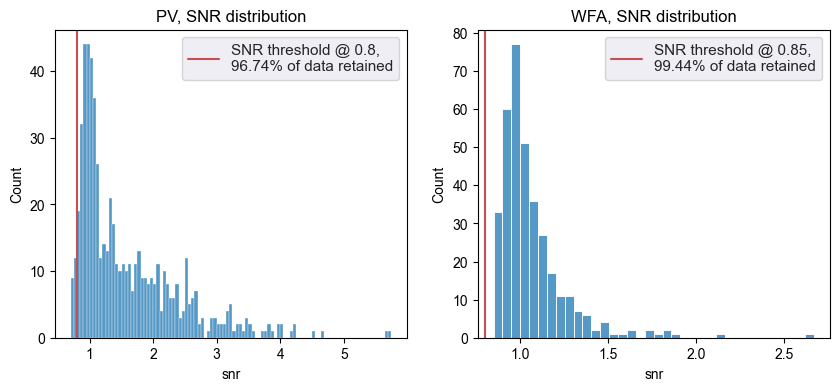

In [6]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axs = axs.ravel()
sns.set_theme()

df_PV = df_snr.query('stain_type == "PV"')
df_WFA = df_snr.query('stain_type == "WFA"')

g0 = sns.histplot(x='snr', data=df_PV, ax=axs[0], binwidth=0.05)
g0.set_title('PV, SNR distribution')
g0.axvline(0.8, c='r', label=f'SNR threshold @ 0.8,\n{np.round(len(df_PV.query("snr > 0.8"))/len(df_PV)*100,2)}% of data retained')
g0.legend()

g1 = sns.histplot(x='snr', data=df_snr.query('stain_type == "WFA"'), ax=axs[1], binwidth=0.05)
g1.set_title('WFA, SNR distribution')
g1.axvline(0.8, c='r', label=f'SNR threshold @ 0.85,\n{np.round(len(df_WFA.query("snr > 0.85"))/len(df_WFA)*100,2)}% of data retained')
g1.legend()

plt.show()

# Retaining only full coloc cell groupings
The SNR threshold may have caused some colocalized cells to become "incomplete." That is, say we had a PV cell that was colocalized to a c-Fos cell, resulting in two entries in our double labeled set: a PV_coloc_w/c-Fos cell, and a c-Fos_coloc_w/_PV cell. It may be the case that this particular PV cell was removed by the SNR threshold, but the c-Fos cell was not. If the PV cell was removed, we would still have that left over c-Fos_coloc_w/_PV cell in our set. 

The kernel of the issue is that we set a threshold based on one stain type, but we want to remove a cell of a different stain type; that is, we want to maintain full coloc groupings among our remaining colocalized cells.

My approach here is to create groupings (sets) of coloc cells roi ids and remove cells who do not meat the following criteria:
- each set must contain exactly the number of roi ids required to create the coloc stain type combinations (2 for double, 3 for triple, and 4 for quad)
- within each image, each unique set must appear the appropriate number of times (2 for double, 3 for triple, and 4 for quad)

However, before creating groupings the following issues must be addressed:
- colocw/ titles are not consistent or accurately named
- roi id strings are not unique across stain types or across images

NOTE because not only are roi id strings reused across stain types, they are reset for each unique image, we must carry out this process on an image by image basis. We may only concat our distributed dfs after subset selection and data replacement (when cols are finally standardized across images and stain type combinations).

Before we can pair up our cells, we must first be able to accurately rename our coloc_w/ cols

## Checking order of coloc_w/ cols
check that coloc cols always appear in order based on the last digit of the filename.
recall that we have the following relations:
- *_2.tif : PV
- *_3.tif : WFA

Here I'm checking that the first coloc_w/ col is always PV, the second coloc_w/ col is always cFos, and so on. Since not all dataframes are complete after snr filtering, I'm only checking where we have a nan in a given coloc_w/ col; the nan in the coloc_w/ col indicates that a cell cannot be colocalized with itself, meaning that the staintype of the nan row corresponds to the staintype of the coloc_w/ column name.


we can take advantage of this ordered relation to construct for us new informative col names. That is, if filenames are always listed in ascending order, always expect PV cells at the top of the dataframe, then cFos, then Npas4 and lastly WFA. If coloc_cols are always listed from left to right in that same order, then we can use the position of a coloc_col to accurately determine it's correct stain_type. 

If we are correct that coloc_w/ columns are always ordered from left to right based on the increasing last digit of the filename, then for all quad labeled dataframes, we expect coloc_w/PV, then coloc_w/_cFos, then coloc_w/Npas4 and lastly coloc_w/WFA. Let's check.

It might vary for triple or double since we only take an ordered subset of stains, but since quad label requires all stains, we expect this ordering to hold for all quad labeled dataframes;

However in this case we only have to worry about the doubled labeled case with only two stain types. So if we can determine that PV is always first, that alone takes care of all other cases

In [7]:
# check that filenames are always reported in ascending order based on last digit of filename
assert np.array([df.filename.is_monotonic_increasing for df in df_doubles_snr]).all() == True

# check that all coloc_cols appear from left to right in the order of the filenames
d_self_stains = {}
for i in range(1,3):
    self_stains = []
    for df in df_doubles_snr:
        # we expect 1:PV, 2,:WFA
        self = df[df.iloc[:,i].isna()]
        if len(self) > 0:
            self_stains.append(self.stain_type.unique())

    # check that we have exactly one unique result across all dfs
    self_stains = np.unique(np.squeeze(self_stains))
    assert len(self_stains) == 1
    
    d_self_stains.update({i: self_stains.item()})

for item in d_self_stains.items():
    print(item)

(1, 'PV')
(2, 'WFA')


perfect. Now we just have to rename some cols and updated roi_ids.

In [8]:
def rename_colocw_cols(df):
    '''
    '''
    # getting all coloc cols
    coloc_cols = [col for col in df.columns if 'colocw/' in col]

    # building ordinal staintype dict
    d_ord = dict([(i, x) for i, x in enumerate(df.stain_type.drop_duplicates())])

    # create new colnames from ordinal staintype dict
    coloc_rename = []
    for i, name in enumerate(coloc_cols):
        coloc_rename.append((name, f'coloc_w/_{d_ord[i]}'))

    # build dict for remapping old colnames
    d_coloc_rename = dict(coloc_rename)

    # rename
    df = df.rename(columns=d_coloc_rename)

    return df


def rename_roi_ids(df):
    '''
    '''
    coloc_cols = [col for col in df.columns if 'coloc_w/' in col]
    for col in coloc_cols:        
        stain = col.split('_')[-1]
        # add stain string to end of roi id if not nan
        df[col] = df[col].apply(lambda x: x+f'_{stain}' if pd.notnull(x) and str(x) != '-' else x)

    df['roi_id'] = df.apply(lambda x: x.roi_id + '_' + x.stain_type, axis=1)

    return df

def count_coloc_groupings(df):
    '''
    '''
    # get coloc_col names
    roi_id_cols = [col for col in df.columns if 'coloc_w/_' in col] + ['roi_id']

    # create grouping tuple
    groups = df.apply(lambda x: tuple(sorted([y for y in list(x[roi_id_cols]) if pd.notnull(y)])), axis=1)

    # build new grouping col
    df['coloc_roi_id_grouping'] = groups

    # counting unique groupings of roi_ids
    groups, counts = np.unique(df.coloc_roi_id_grouping, return_counts=True)

    # build dict
    d_group_counts = dict(zip(groups, counts))

    # remove dict entries of lonely cells
    d_group_counts = {k:d_group_counts[k] for k in d_group_counts if not '-' in k}

    # map groupings to counts, NaN if lonely
    # df['roi_id_grouping_counts'] = df.coloc_roi_id_grouping.map(d_group_counts)
    
    # for some reason dataframe mapping gives me a weird index error. this seems to work just though.
    groupings = np.array(df.coloc_roi_id_grouping)
    counts = []
    for grp in groupings:
        if grp in d_group_counts:
            counts.append(d_group_counts[grp])
        else:
            counts.append(np.nan)

    # set new col
    df['roi_id_grouping_counts'] = counts

    return df

def paired(df, coloc_type):
    '''
    '''
    # remove unnecesary index col
    if 'index' in df.columns:
        df = df.drop('index', axis=1)

    # enforce coloc_type
    if not coloc_type in {'double', 'triple', 'quad'}:
        raise ValueError('coloc_type must be either "double", "triple", or "quad"')
    
    cols = df.columns
    n_coloc_cols = np.array(['colocw/' in f for f in list(cols)]).sum()

    if coloc_type == 'double':
        # check that the number of coloc cols is exactly 2, and 
        # that there are exactly 2 unique (single) stain_types in df
        assert n_coloc_cols == 2
        assert len(df.stain_type.unique()) == 2

        # rename coloc_w/ cols; rename roi_id strings
        df_rename = rename_roi_ids(rename_colocw_cols(df))

        # create roi id coloc groupings, count groupings
        df_grouped = count_coloc_groupings(df_rename)

        # only return rows that were fully paired; for double we expect exactly 2 (or NaN for lonely cells)
        df_paired = df_grouped[(df_grouped.roi_id_grouping_counts == 2) | (df_grouped.roi_id_grouping_counts.isna())]

    if coloc_type == 'triple':
        # check that there are exactly 3 coloc cols, and that
        # there are exactly 3 unique (single) stain_types in df
        assert n_coloc_cols == 3
        assert len(df.stain_type.unique()) == 3

        # rename coloc_w/ cols; rename roi_id strings
        df_rename = rename_roi_ids(rename_colocw_cols(df))

        # create roi id coloc groupings, count groupings
        df_grouped = count_coloc_groupings(df_rename)

        # only return rows that were fully paired; for triple we expect exactly 3 (or NaN for lonely cells)
        df_paired = df_grouped[(df_grouped.roi_id_grouping_counts == 3)| (df_grouped.roi_id_grouping_counts.isna())]
    
    if coloc_type == 'quad':
        # check that there are exactly 4 coloc cols, and that
        # there are exactly 3 unique (single) stain_types in df
        assert n_coloc_cols == 4
        assert len(df.stain_type.unique()) == 4

        # rename coloc_w/ cols; rename roi_id strings
        df_rename = rename_roi_ids(rename_colocw_cols(df))

        # create roi id coloc groupings, count groupings
        df_grouped = count_coloc_groupings(df_rename)

        # only return rows that were fully paired; for quad we expect exactly 4 (or NaN for lonely cells)
        df_paired = df_grouped[(df_grouped.roi_id_grouping_counts == 4) | (df_grouped.roi_id_grouping_counts.isna())]
    
    return df_paired

doubles_paired = [paired(df, coloc_type='double') for df in df_doubles_snr]

In [9]:
# just to be extra extra sure, check that the number of double/triple/quad labeled cell remaining is divisible by 2/3/4 respectively
for df in doubles_paired:
    assert len(df[df.iloc[:,1] != '-']) % 2 == 0

# since we only have doubles between PV and WFA, there is no need for additional aggregation
# across stain types; we can do the final concat right here!
df_coloc = pd.concat(doubles_paired)
df_coloc

,stain,coloc_w/_PV,coloc_w/_WFA,roi_id,CoM_x,CoM_y,pixel_area,background,mean_intensity,median_intensity,...,kurtosis,filename,analysis_date,rat_n,treatment,stain_type,image_name,snr,coloc_roi_id_grouping,roi_id_grouping_counts
0,Parvalbumin,NaN,0-FFF-00004_WFA,0-000-00001_PV,371.51,157.23,236.0,187.0420,384.5552,400.1461,...,-0.3940,KET-8-10F_3.5_D_2.tif,Mon Mar 18 14:13:43 PDT 2024,KET-8-10,6mg/kg,PV,KET-8-10F_3.5_D,2.055983,"(0-000-00001_PV, 0-FFF-00004_WFA)",2.0
2,Parvalbumin,-,-,0-000-00003_PV,220.23,243.85,245.0,187.0420,237.0273,236.5289,...,-0.1545,KET-8-10F_3.5_D_2.tif,Mon Mar 18 14:13:43 PDT 2024,KET-8-10,6mg/kg,PV,KET-8-10F_3.5_D,1.267241,"(-, -, 0-000-00003_PV)",NaN
3,Parvalbumin,-,-,0-000-00002_PV,254.08,25.71,321.0,187.0420,198.5742,185.3672,...,0.3672,KET-8-10F_3.5_D_2.tif,Mon Mar 18 14:13:43 PDT 2024,KET-8-10,6mg/kg,PV,KET-8-10F_3.5_D,1.061656,"(-, -, 0-000-00002_PV)",NaN
4,Parvalbumin,-,-,0-000-00000_PV,495.12,147.14,243.0,187.0420,202.6783,187.2926,...,0.9937,KET-8-10F_3.5_D_2.tif,Mon Mar 18 14:13:43 PDT 2024,KET-8-10,6mg/kg,PV,KET-8-10F_3.5_D,1.083598,"(-, -, 0-000-00000_PV)",NaN
5,WFA hand-drawn,-,-,0-FFF-00006_WFA,144.35,58.88,291.0,105.1121,97.8798,92.6631,...,3.6423,KET-8-10F_3.5_D_3.tif,Mon Mar 18 14:13:43 PDT 2024,KET-8-10,6mg/kg,WFA,KET-8-10F_3.5_D,0.931194,"(-, -, 0-FFF-00006_WFA)",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,WFA hand-drawn,-,-,0-FFF-00004_WFA,19.58,186.31,263.0,98.6284,94.9338,91.3409,...,11.9728,KET-7-6F_3.9_A_3.tif,Mon Mar 18 14:11:52 PDT 2024,KET-7-6,Saline,WFA,KET-7-6F_3.9_A,0.962540,"(-, -, 0-FFF-00004_WFA)",NaN
15,WFA hand-drawn,-,-,0-FFF-00001_WFA,274.07,17.07,363.0,98.6284,104.5248,96.5755,...,2.0821,KET-7-6F_3.9_A_3.tif,Mon Mar 18 14:11:52 PDT 2024,KET-7-6,Saline,WFA,KET-7-6F_3.9_A,1.059784,"(-, -, 0-FFF-00001_WFA)",NaN
16,WFA hand-drawn,0-000-00006_PV,NaN,0-FFF-00005_WFA,405.90,363.68,374.0,98.6284,97.9680,92.2411,...,2.0406,KET-7-6F_3.9_A_3.tif,Mon Mar 18 14:11:52 PDT 2024,KET-7-6,Saline,WFA,KET-7-6F_3.9_A,0.993304,"(0-000-00006_PV, 0-FFF-00005_WFA)",2.0
17,WFA hand-drawn,0-000-00004_PV,NaN,0-FFF-00002_WFA,302.79,43.41,1056.0,98.6284,147.3145,128.3873,...,2.2919,KET-7-6F_3.9_A_3.tif,Mon Mar 18 14:11:52 PDT 2024,KET-7-6,Saline,WFA,KET-7-6F_3.9_A,1.493632,"(0-000-00004_PV, 0-FFF-00002_WFA)",2.0


In [10]:
# which cols have nans, how many?
print('Nan per col:')
print(df_coloc.isna().sum())
# it looks like we have no nans! nothing to drop here.

# how many duplicated rows do we have?
print('\nTotal n of duplicated rows:')

# it's best to count duplicates on the numeric data to avoid false negatives due to 
# errors in spelling or systematic labeling
print(df_coloc.iloc[:,3:].duplicated().sum())

Nan per col:
stain                          0
coloc_w/_PV                  223
coloc_w/_WFA                 223
roi_id                         0
CoM_x                          0
CoM_y                          0
pixel_area                     0
background                     0
mean_intensity                 0
median_intensity               0
mode_intensity                 0
stdev                          0
mean-background                0
integrated_density             0
min                            0
max                            0
area_legacy                    0
mean_legacy                    0
integrated_density_legacy      0
raw_integrated_density         0
CoM_x_legacy                   0
CoM_y_legacy                   0
min_legacy                     0
max_legacy                     0
ferets_diameter                0
feret_x                        0
feret_y                        0
feret_angle                    0
feret_min                      0
circularity                   

In [11]:
# the rows that have nans are all the rows I expect and so I'm comfortable filling these all in w/ '-'
df_coloc = df_coloc.fillna('-').drop('roi_id_grouping_counts', axis=1) # also don't need this col anymore
df_coloc

,stain,coloc_w/_PV,coloc_w/_WFA,roi_id,CoM_x,CoM_y,pixel_area,background,mean_intensity,median_intensity,...,skewness,kurtosis,filename,analysis_date,rat_n,treatment,stain_type,image_name,snr,coloc_roi_id_grouping
0,Parvalbumin,-,0-FFF-00004_WFA,0-000-00001_PV,371.51,157.23,236.0,187.0420,384.5552,400.1461,...,-0.1631,-0.3940,KET-8-10F_3.5_D_2.tif,Mon Mar 18 14:13:43 PDT 2024,KET-8-10,6mg/kg,PV,KET-8-10F_3.5_D,2.055983,"(0-000-00001_PV, 0-FFF-00004_WFA)"
2,Parvalbumin,-,-,0-000-00003_PV,220.23,243.85,245.0,187.0420,237.0273,236.5289,...,0.2275,-0.1545,KET-8-10F_3.5_D_2.tif,Mon Mar 18 14:13:43 PDT 2024,KET-8-10,6mg/kg,PV,KET-8-10F_3.5_D,1.267241,"(-, -, 0-000-00003_PV)"
3,Parvalbumin,-,-,0-000-00002_PV,254.08,25.71,321.0,187.0420,198.5742,185.3672,...,0.9405,0.3672,KET-8-10F_3.5_D_2.tif,Mon Mar 18 14:13:43 PDT 2024,KET-8-10,6mg/kg,PV,KET-8-10F_3.5_D,1.061656,"(-, -, 0-000-00002_PV)"
4,Parvalbumin,-,-,0-000-00000_PV,495.12,147.14,243.0,187.0420,202.6783,187.2926,...,1.0812,0.9937,KET-8-10F_3.5_D_2.tif,Mon Mar 18 14:13:43 PDT 2024,KET-8-10,6mg/kg,PV,KET-8-10F_3.5_D,1.083598,"(-, -, 0-000-00000_PV)"
5,WFA hand-drawn,-,-,0-FFF-00006_WFA,144.35,58.88,291.0,105.1121,97.8798,92.6631,...,1.6958,3.6423,KET-8-10F_3.5_D_3.tif,Mon Mar 18 14:13:43 PDT 2024,KET-8-10,6mg/kg,WFA,KET-8-10F_3.5_D,0.931194,"(-, -, 0-FFF-00006_WFA)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,WFA hand-drawn,-,-,0-FFF-00004_WFA,19.58,186.31,263.0,98.6284,94.9338,91.3409,...,2.2783,11.9728,KET-7-6F_3.9_A_3.tif,Mon Mar 18 14:11:52 PDT 2024,KET-7-6,Saline,WFA,KET-7-6F_3.9_A,0.962540,"(-, -, 0-FFF-00004_WFA)"
15,WFA hand-drawn,-,-,0-FFF-00001_WFA,274.07,17.07,363.0,98.6284,104.5248,96.5755,...,1.3000,2.0821,KET-7-6F_3.9_A_3.tif,Mon Mar 18 14:11:52 PDT 2024,KET-7-6,Saline,WFA,KET-7-6F_3.9_A,1.059784,"(-, -, 0-FFF-00001_WFA)"
16,WFA hand-drawn,0-000-00006_PV,-,0-FFF-00005_WFA,405.90,363.68,374.0,98.6284,97.9680,92.2411,...,1.3330,2.0406,KET-7-6F_3.9_A_3.tif,Mon Mar 18 14:11:52 PDT 2024,KET-7-6,Saline,WFA,KET-7-6F_3.9_A,0.993304,"(0-000-00006_PV, 0-FFF-00005_WFA)"
17,WFA hand-drawn,0-000-00004_PV,-,0-FFF-00002_WFA,302.79,43.41,1056.0,98.6284,147.3145,128.3873,...,1.4136,2.2919,KET-7-6F_3.9_A_3.tif,Mon Mar 18 14:11:52 PDT 2024,KET-7-6,Saline,WFA,KET-7-6F_3.9_A,1.493632,"(0-000-00004_PV, 0-FFF-00002_WFA)"


# Building Dummy Cols

In [12]:
def get_dummies(row):
    roi_ids = (row['coloc_w/_PV'], row['coloc_w/_WFA'], row.roi_id)
    dummy_PV, dummy_WFA = (False, False)
    for rid in roi_ids:
        if 'PV' in rid:
            dummy_PV = True
        if 'WFA' in rid:
            dummy_WFA = True
    
    return dummy_PV, dummy_WFA

df_coloc['dummy_PV'], df_coloc['dummy_WFA'] = zip(*df_coloc.apply(get_dummies, axis=1))
df_coloc['coloc_roi_id_grouping'] = df_coloc.coloc_roi_id_grouping.apply(lambda x: tuple([y for y in x if not y == '-']))

df_coloc

,stain,coloc_w/_PV,coloc_w/_WFA,roi_id,CoM_x,CoM_y,pixel_area,background,mean_intensity,median_intensity,...,filename,analysis_date,rat_n,treatment,stain_type,image_name,snr,coloc_roi_id_grouping,dummy_PV,dummy_WFA
0,Parvalbumin,-,0-FFF-00004_WFA,0-000-00001_PV,371.51,157.23,236.0,187.0420,384.5552,400.1461,...,KET-8-10F_3.5_D_2.tif,Mon Mar 18 14:13:43 PDT 2024,KET-8-10,6mg/kg,PV,KET-8-10F_3.5_D,2.055983,"(0-000-00001_PV, 0-FFF-00004_WFA)",True,True
2,Parvalbumin,-,-,0-000-00003_PV,220.23,243.85,245.0,187.0420,237.0273,236.5289,...,KET-8-10F_3.5_D_2.tif,Mon Mar 18 14:13:43 PDT 2024,KET-8-10,6mg/kg,PV,KET-8-10F_3.5_D,1.267241,"(0-000-00003_PV,)",True,False
3,Parvalbumin,-,-,0-000-00002_PV,254.08,25.71,321.0,187.0420,198.5742,185.3672,...,KET-8-10F_3.5_D_2.tif,Mon Mar 18 14:13:43 PDT 2024,KET-8-10,6mg/kg,PV,KET-8-10F_3.5_D,1.061656,"(0-000-00002_PV,)",True,False
4,Parvalbumin,-,-,0-000-00000_PV,495.12,147.14,243.0,187.0420,202.6783,187.2926,...,KET-8-10F_3.5_D_2.tif,Mon Mar 18 14:13:43 PDT 2024,KET-8-10,6mg/kg,PV,KET-8-10F_3.5_D,1.083598,"(0-000-00000_PV,)",True,False
5,WFA hand-drawn,-,-,0-FFF-00006_WFA,144.35,58.88,291.0,105.1121,97.8798,92.6631,...,KET-8-10F_3.5_D_3.tif,Mon Mar 18 14:13:43 PDT 2024,KET-8-10,6mg/kg,WFA,KET-8-10F_3.5_D,0.931194,"(0-FFF-00006_WFA,)",False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,WFA hand-drawn,-,-,0-FFF-00004_WFA,19.58,186.31,263.0,98.6284,94.9338,91.3409,...,KET-7-6F_3.9_A_3.tif,Mon Mar 18 14:11:52 PDT 2024,KET-7-6,Saline,WFA,KET-7-6F_3.9_A,0.962540,"(0-FFF-00004_WFA,)",False,True
15,WFA hand-drawn,-,-,0-FFF-00001_WFA,274.07,17.07,363.0,98.6284,104.5248,96.5755,...,KET-7-6F_3.9_A_3.tif,Mon Mar 18 14:11:52 PDT 2024,KET-7-6,Saline,WFA,KET-7-6F_3.9_A,1.059784,"(0-FFF-00001_WFA,)",False,True
16,WFA hand-drawn,0-000-00006_PV,-,0-FFF-00005_WFA,405.90,363.68,374.0,98.6284,97.9680,92.2411,...,KET-7-6F_3.9_A_3.tif,Mon Mar 18 14:11:52 PDT 2024,KET-7-6,Saline,WFA,KET-7-6F_3.9_A,0.993304,"(0-000-00006_PV, 0-FFF-00005_WFA)",True,True
17,WFA hand-drawn,0-000-00004_PV,-,0-FFF-00002_WFA,302.79,43.41,1056.0,98.6284,147.3145,128.3873,...,KET-7-6F_3.9_A_3.tif,Mon Mar 18 14:11:52 PDT 2024,KET-7-6,Saline,WFA,KET-7-6F_3.9_A,1.493632,"(0-000-00004_PV, 0-FFF-00002_WFA)",True,True


# Enforcing complete subgraphs

First checking that the total number of PV on WFA matches the total number of WFA on PV

In [13]:
# do our doubles agree?
import itertools

print('double labeled differences: ')
for stain_x, stain_y in itertools.combinations(['PV', 'WFA'],2):
    x_on_y = df_coloc.query(f'dummy_{stain_x} == True and dummy_{stain_y} == True and stain_type == "{stain_x}"')
    y_on_x = df_coloc.query(f'dummy_{stain_x} == True and dummy_{stain_y} == True and stain_type == "{stain_y}"')
    diff = x_on_y.__len__() - y_on_x.__len__()
    print(f'{stain_x}, {stain_y}:    {diff}')

double labeled differences: 
PV, WFA:    0


Now checking for each image, if I were to look up a given double labeled PV cell, look at it's paired colocalization roi_ids, look up the paired colocalization roi_ids of THOSE cells, would I find the original PV cell again? If we have a complete subgraph, that is for a set of nodes that form a subgraph (in thise case up to two nodes for double labeled data) do all these nodes "point" to each other?

In [14]:
l_imgs = [df_coloc.query(f'image_name == "{img}"') for img in df_coloc.image_name.unique()]

l_imgs_subgraphs = []
for img in l_imgs:
    
    l_subgraph_complete = []
    for rid in img.roi_id:
        self = rid
        self_grouping = img.query(f'roi_id == "{rid}"').coloc_roi_id_grouping.values.item()

        target_groupings = []
        for target_rid in self_grouping:
            if not target_rid == self:
                target_grouping = img.query(f'roi_id == "{target_rid}"').coloc_roi_id_grouping.values.item()
                target_groupings.append(target_grouping)
        
        eval = []
        for grp in target_groupings:
            eval.append(self_grouping == grp)
        
        subgraph_complete = {'roi_id': self, 'is_complete_subgraph': np.all(eval)}
        l_subgraph_complete.append(subgraph_complete)

    l_imgs_subgraphs.append(img.merge(pd.DataFrame(l_subgraph_complete)))

df_coloc_sg = pd.concat(l_imgs_subgraphs)
if np.all(df_coloc_sg.is_complete_subgraph):
    print('all subgraphs for all images are complete!')

all subgraphs for all images are complete!


# Standard analyses first
our usual normalized intensity and mean cell counts

## Adjusting Mean-Background

In [15]:
def adjust_mmbg(df):
    '''
    '''
    # remove unnecesary index col
    if 'index' in df.columns:
        df = df.drop('index', axis=1)

    # add minimum observed intensity 
    adjusted_mmbg = []
    for stain in df.stain_type.unique():
        # separate by stain
        df_stain = df.query(f'stain_type == "{stain}"').reset_index()

        # compute new mean-background col
        df_stain['mean-background'] = df_stain.loc[: ,'mean_intensity'].astype('f') - df_stain.loc[:, 'background'].astype('f')

        # get min mean-background (some negative number)
        min_mmbg = df_stain['mean-background'].min()

        # add the absolute value of min to all other cells of the same stain
        df_stain['adjusted_mean-background'] = df_stain['mean-background'] + abs(min_mmbg)

        # toss back into list
        adjusted_mmbg.append(df_stain)

    df_adjusted = pd.concat(adjusted_mmbg)

    return df_adjusted

df_adjusted = adjust_mmbg(df_coloc_sg)
print(df_adjusted.shape)
df_adjusted.head()

(942, 48)


,index,stain,coloc_w/_PV,coloc_w/_WFA,roi_id,CoM_x,CoM_y,pixel_area,background,mean_intensity,...,rat_n,treatment,stain_type,image_name,snr,coloc_roi_id_grouping,dummy_PV,dummy_WFA,is_complete_subgraph,adjusted_mean-background
0,0,Parvalbumin,-,0-FFF-00004_WFA,0-000-00001_PV,371.51,157.23,236.0,187.0420,384.5552,...,KET-8-10,6mg/kg,PV,KET-8-10F_3.5_D,2.055983,"(0-000-00001_PV, 0-FFF-00004_WFA)",True,True,True,244.606201
1,1,Parvalbumin,-,-,0-000-00003_PV,220.23,243.85,245.0,187.0420,237.0273,...,KET-8-10,6mg/kg,PV,KET-8-10F_3.5_D,1.267241,"(0-000-00003_PV,)",True,False,True,97.078293
2,2,Parvalbumin,-,-,0-000-00002_PV,254.08,25.71,321.0,187.0420,198.5742,...,KET-8-10,6mg/kg,PV,KET-8-10F_3.5_D,1.061656,"(0-000-00002_PV,)",True,False,True,58.625198
3,3,Parvalbumin,-,-,0-000-00000_PV,495.12,147.14,243.0,187.0420,202.6783,...,KET-8-10,6mg/kg,PV,KET-8-10F_3.5_D,1.083598,"(0-000-00000_PV,)",True,False,True,62.729294
4,0,Parvalbumin hand-drawn,-,0-FFF-00005_WFA,0-FFF-00014_PV,176.41,298.77,231.0,173.3763,154.3255,...,KET-8-8,6mg/kg,PV,KET-8-8F_3.5_D,0.890119,"(0-FFF-00005_WFA, 0-FFF-00014_PV)",True,True,True,28.042206


In [16]:
##### LAST SECOND ANIMAL DROPPED FROM SET #####
df_adjusted = df_adjusted.query('rat_n != "KET-7-6"').reset_index().copy(deep=True)
df_adjusted

,level_0,index,stain,coloc_w/_PV,coloc_w/_WFA,roi_id,CoM_x,CoM_y,pixel_area,background,...,rat_n,treatment,stain_type,image_name,snr,coloc_roi_id_grouping,dummy_PV,dummy_WFA,is_complete_subgraph,adjusted_mean-background
0,0,0,Parvalbumin,-,0-FFF-00004_WFA,0-000-00001_PV,371.51,157.23,236.0,187.0420,...,KET-8-10,6mg/kg,PV,KET-8-10F_3.5_D,2.055983,"(0-000-00001_PV, 0-FFF-00004_WFA)",True,True,True,244.606201
1,1,1,Parvalbumin,-,-,0-000-00003_PV,220.23,243.85,245.0,187.0420,...,KET-8-10,6mg/kg,PV,KET-8-10F_3.5_D,1.267241,"(0-000-00003_PV,)",True,False,True,97.078293
2,2,2,Parvalbumin,-,-,0-000-00002_PV,254.08,25.71,321.0,187.0420,...,KET-8-10,6mg/kg,PV,KET-8-10F_3.5_D,1.061656,"(0-000-00002_PV,)",True,False,True,58.625198
3,3,3,Parvalbumin,-,-,0-000-00000_PV,495.12,147.14,243.0,187.0420,...,KET-8-10,6mg/kg,PV,KET-8-10F_3.5_D,1.083598,"(0-000-00000_PV,)",True,False,True,62.729294
4,4,0,Parvalbumin hand-drawn,-,0-FFF-00005_WFA,0-FFF-00014_PV,176.41,298.77,231.0,173.3763,...,KET-8-8,6mg/kg,PV,KET-8-8F_3.5_D,0.890119,"(0-FFF-00005_WFA, 0-FFF-00014_PV)",True,True,True,28.042206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
867,331,11,WFA hand-drawn,0-000-00003_PV,-,0-FFF-00002_WFA,446.40,285.14,1363.0,89.6859,...,KET-7-5,Saline,WFA,KET-7-5F_3.4_B,1.319862,"(0-000-00003_PV, 0-FFF-00002_WFA)",True,True,True,48.500000
868,341,10,WFA hand-drawn,-,-,0-FFF-00003_WFA,298.42,403.86,1205.0,80.1185,...,KET-7-5,Saline,WFA,KET-7-5F_3.4_A,1.716207,"(0-FFF-00003_WFA,)",False,True,True,77.194290
869,342,11,WFA hand-drawn,0-000-00007_PV,-,0-FFF-00002_WFA,270.06,409.70,899.0,80.1185,...,KET-7-5,Saline,WFA,KET-7-5F_3.4_A,1.478269,"(0-000-00007_PV, 0-FFF-00002_WFA)",True,True,True,58.131096
870,343,12,WFA hand-drawn,0-000-00003_PV,-,0-FFF-00004_WFA,346.99,484.01,974.0,80.1185,...,KET-7-5,Saline,WFA,KET-7-5F_3.4_A,1.235295,"(0-000-00003_PV, 0-FFF-00004_WFA)",True,True,True,38.664398


In [17]:
# dont forget to write the final dataset to disk!
df_adjusted.to_csv('POST_VR5_FINAL.csv')

## Normalize intensity

In [18]:
def normalize_intensity(df, norm_condition, col='mean-background'):
    '''
    computes the mean of rows of the norm_condition and divides mean-background by this mean,
    normalizing all data to the mean of the norm_condition. sets normalized value into new
    column called "norm mean-background" and returns new dataframe containing normalized intensity.
    '''
    df_norm = df[df.treatment == norm_condition]
    norm_mean = df_norm[col].astype('f').mean()

    df_norm = df.copy(deep=True)
    df_norm[f'norm_{col}'] = df[col].astype('f') / norm_mean

    # quickly check that the mean of the norm condition is set to about 1.00000
    # this is never exatly 1 due to small rounding errors from floating point operations
    assert round(df_norm[df_norm.treatment == norm_condition][f'norm_{col}'].mean(), 4) == 1
    
    return df_norm

def prism_reorg(df, col='norm_mean-background'):
    '''
    Takes just the norm_mean-background intensity col per rat, groups by treatment
    and 
    '''
    treatments = np.unique(df.treatment)
    reorg = []

    for t in treatments:
        df_treat = df[df.treatment == t]
        norm_int_ratn = []
        treatment_ratns = np.unique(df_treat.rat_n)

        for rat in treatment_ratns:
            norm_int = df_treat[df_treat.rat_n == rat][col]
            df_normint = pd.DataFrame({t: norm_int}).reset_index(drop=True)
            norm_int_ratn.append(df_normint)

        # concat "vertically"
        df_ratn_cols = pd.concat(norm_int_ratn, axis=0).reset_index(drop=True)

        # write csv to disk
        reorg.append(df_ratn_cols)
    
    # concat "horizontally"
    df_prism_reorg = pd.concat(reorg, axis=1)

    return df_prism_reorg

In [19]:
if os.path.exists('NORM') and os.path.isdir('NORM'):
    shutil.rmtree('NORM')
os.mkdir('NORM')

if os.path.exists('PRISM') and os.path.isdir('PRISM'):
    shutil.rmtree('PRISM')
os.mkdir('PRISM')

# we have to do some creative looping to access the nested coloc stain type
# getting every combination of four booleans (position matters)
# except the last one (all False) which would mean the cell had 0 stain types
bool_combs = list(itertools.product([True, False], repeat=2))[:-1]
group = 'KET-POSTVR5'

for bcomb in bool_combs:
    # copied from other ketamine image analysis notebook, removed references to cFos and Npas4
    stains = np.array(['PV', 'WFA'])
    coloc_PV, coloc_WFA = [*bcomb]

    q = []
    if coloc_PV:
        q.append(f'dummy_PV == {coloc_PV}')
    if coloc_WFA:
        q.append(f'dummy_WFA == {coloc_WFA}')

    query = ' and '.join(q)
    df_subset = df_adjusted.query(query)
    print(len(df_subset), query)

    for stain in df_subset.stain_type.unique():
        self = stain
        stains_filtered = stains.copy()[np.array(bcomb)]
        nonself = np.delete(stains_filtered, np.argwhere(stains_filtered == self))

        df_stain = df_subset.query(f'stain_type == "{self}"')
        
        if len(nonself) == 0:
            coloc_stain_type = f'single_{self}'
        
        if len(nonself) == 1:
            coloc_stain_type = f'{self}_coloc_w_{nonself[0]}'
        
        if len(nonself) == 2:
            coloc_stain_type = f'{self}_coloc_w_{nonself[0]},{nonself[1]}'

        if len(nonself) == 3:
            coloc_stain_type = f'quad_{self}'


        # normalize to Saline
        df_norm = normalize_intensity(df_stain, norm_condition='Saline', col='adjusted_mean-background')
        df_norm['coloc_stain_type'] = coloc_stain_type
        df_norm.to_csv(f'NORM/{group}_{coloc_stain_type}_NORM.csv')

        # reorganize into cols for prism
        df_prism = prism_reorg(df_norm, col='norm_adjusted_mean-background')
        df_prism.to_csv(f'PRISM/{group}_{coloc_stain_type}_PRISM.csv')

416 dummy_PV == True and dummy_WFA == True


751 dummy_PV == True
537 dummy_WFA == True


## Counting Mean Cell Ns

In [20]:
def count_imgs(df, sid, iid):
    '''
    takes a dataframe and counts the number of unique strings that occur in the 
    "image_name" col for each rat in "rat_n" col
    args:
        df: pd.core.frame.DataFrame(n, m) 
            n: the number of rows, 
            m: the number of features
        sid: str, denoting the name of the col containing unique subject ids
        iid: str, denoting the name of the col containing unique image ids
    return:
        df_imgn: pd.core.frame.DataFrame(n=|sid|), m=2)
            n: the number of rows, equal to the cardinality of the sid set
            (the number of unique ID strings in sid)
            this df contains 2 cols: a sid col, and an iid col containing counts
    '''
    assert iid in df.columns

    df_imgn = df.groupby([sid])[[sid, iid]]\
        .apply(lambda x: len(np.unique(x[iid])))\
        .reset_index(name='image_n')
    
    return df_imgn

def count_cells(df, cols):
    '''
    takes a df and counts the number of instances each distinct row 
    (created by unique combinations of labels from columns indicated
    by cols arg); counts are reported in a new col called "cell_counts"
    args:
        df: pd.core.frame.DataFrame(N, M); N: the number of rows, M: the
            number of cols (assumed to have already been split by stain_type)
        cols: list(n), n: the number of cols over which to count distinct rows
    return:
        df_counts: pd.core.frame.DataFrame(N,M+1)
    '''
    df_counts = df.value_counts(cols)\
        .reset_index(name='cell_counts')\
        .sort_values(by=cols)
    
    return df_counts

def sum_cells(df, cols, iid):
    '''
    takes cell count df, groups by cols denoted in cols list and computes sum
    of cell_counts col for each group. Adds new column "cell_count_sums"
    containing sums.
    args:
        df: pd.core.frame.DataFrame(N, M), N: the number of rows (N=|id_col|),
            M: the number of cols, must contain col called "cell_counts"
        cols: list(M-2), list containing col name strings that define each group 
            for group by and reduction (in this case summing)
        iid: str, denotes 
    return:
        df_sums: pd.core.frame.DataFrame; dataframe containing summed cell
            counts per subject id.
    '''
    # remove image id col (we want to sum counts across all images per rat)
    reduce_cols = list(filter(lambda x: x != iid, cols))

    if 'scaled_counts' in df.columns:
            # group by, reduce 
        df_sums = df.groupby(by=reduce_cols)[cols]\
            .apply(lambda x: np.sum(x.scaled_counts))\
            .reset_index(name='cell_count_sums')
    
    else:
        # group by, reduce 
        df_sums = df.groupby(by=reduce_cols)[df.columns]\
            .apply(lambda x: np.sum(x.cell_counts))\
            .reset_index(name='cell_count_sums')
    
    return df_sums

def average_counts(df_sums, df_ns, cols, sid, iid):
    '''
    takes df of cell count sums and df of image ns, and computes the mean cell 
    n (divides cell count sums by the number of images) for each subject.
    args:
        df_sums: pd.core.frame.DataFrame(ni, mi), ni: the number of rows
            (ni=|sid|), mi: the number of cols (mi = |cols|); must 
            contain a col "cell_count_sums". 
        df_ns: pd.core.frame.DataFrame(nj, mj), nj: the number of rows 
            (nj=|sid|), mj: the number of cols (mj=2); must contain a col
            "image_n" 
        cols: list(n), n: the number of cols (contains all cols necessary to 
            create every unique group combination)
        sid: str, denoting the name of the col containing unique subject ids
        iid: str, denoting the name of the col containing unique image ids
    return:
        mean_cell_ns: pd.core.frame.DataFrame(N,M), N: the number of rows (N=
        |sid|), M: the number of cols (M=|cols|+2)
        
    '''
    # list of cols with out image id, since it was removed during the reduction step
    reduce_cols = list(filter(lambda x: x != iid, cols))

    # compute mean cell n
    mean_cell_ns = df_sums.join(df_ns.set_index(sid), on=sid, how='inner')\
        .sort_values(by=reduce_cols)
    mean_cell_ns['mean_cell_n'] = mean_cell_ns.cell_count_sums / mean_cell_ns.image_n

    # reorder so that subject id is the first col
    col_reorder = [sid] + list(filter(lambda x: x != sid, list(mean_cell_ns.columns)))
    mean_cell_ns = mean_cell_ns[col_reorder]

    return mean_cell_ns

def mean_cell_n(df_stain, df_full, cols, sid, iid, return_counts=False):
    '''
    wrapper function to compute mean cell ns; magnification/zoom factor 
    is assuemd to be equal across all images. NOTE that we count total image
    ns based on full cleaned dataset: it may be the case the not every image
    contains every stain type combination, and we must still count images
    with 0 cells of a particular stain type towards the total number of images.
    args:
        df_stain: pd.core.frame.DataFrame; df containing data for a given stain type
        df_full: pd.core.frame.DataFrame; df containing data for full (cleaned) set
        cols: list, contains str denoting col names for grouping
        sid: str, col name denoting col containing unique subject ids
        iid: str, col name denoting col containing unique image ids
        return_counts: bool, flag for added utility during debugging
    return:
        mean_cell_ns: pd.core.frame.DataFrame; df containing final mean cell ns
        cell_counts: pd.core.frame. DataFram; df containing cell counts per
            image (for debugging)
        
    '''
    # count n of unique image names per subject
    img_ns = count_imgs(df_full, sid, iid)

    # count n of cells per image for each subject
    cell_counts = count_cells(df_stain, cols)

    # sum cell counts across all images for each subject
    cell_sums = sum_cells(cell_counts, cols, iid)

    # compute mean cell count per image for each subject
    mean_cell_ns = average_counts(cell_sums, img_ns, cols, sid, iid)

    if not return_counts:
        return mean_cell_ns
    
    return (cell_counts, mean_cell_ns)

In [21]:
if os.path.exists('mean_cell_ns') and os.path.isdir('mean_cell_ns'):
    shutil.rmtree('mean_cell_ns')
os.mkdir('mean_cell_ns')

# we have to do some creative looping to access the nested coloc stain type
# getting every combination of four booleans (position matters)
# except the last one (all False) which would mean the cell had 0 stain types

# count n of unique image names per subject
sid = 'rat_n'
iid = 'image_name'
cols = ['treatment', 'stain_type', sid, iid]
group = 'KET-POSTVR5'

bool_combs = list(itertools.product([True, False], repeat=2))[:-1]

for bcomb in bool_combs:
    # copied from other ketamine image analysis notebook, removed references to cFos and Npas4
    stains = np.array(['PV', 'WFA'])
    coloc_PV, coloc_WFA = [*bcomb]

    q = []
    if coloc_PV:
        q.append(f'dummy_PV == {coloc_PV}')
    if coloc_WFA:
        q.append(f'dummy_WFA == {coloc_WFA}')

    query = ' and '.join(q)
    df_subset = df_adjusted.query(query)
    print(len(df_subset), query)

    for stain in df_subset.stain_type.unique():
        self = stain
        stains_filtered = stains.copy()[np.array(bcomb)]
        nonself = np.delete(stains_filtered, np.argwhere(stains_filtered == self))

        df_stain = df_subset.query(f'stain_type == "{self}"')
        
        if len(nonself) == 0:
            coloc_stain_type = f'single_{self}'
        
        if len(nonself) == 1:
            coloc_stain_type = f'{self}_coloc_w_{nonself[0]}'
        
        if len(nonself) == 2:
            coloc_stain_type = f'{self}_coloc_w_{nonself[0]},{nonself[1]}'

        if len(nonself) == 3:
            coloc_stain_type = f'quad_{self}'

        # compute mean cell ns
        df_means = mean_cell_n(df_stain, df_coloc, cols, sid, iid)
        df_means['coloc_stain_type'] = coloc_stain_type

        # write to disk
        df_means.to_csv(f'mean_cell_ns/{group}_{coloc_stain_type}_mean_cell_ns.csv')

416 dummy_PV == True and dummy_WFA == True
751 dummy_PV == True
537 dummy_WFA == True


In [23]:
import shutil

if os.path.exists('NORM_MEANS') and os.path.isdir('NORM_MEANS'):
    shutil.rmtree('NORM_MEANS')

os.mkdir('NORM_MEANS')
for f in os.listdir('NORM'):
    df = pd.read_csv(f'NORM/{f}')

    df_means = df.groupby('rat_n')['norm_adjusted_mean-background'].mean().reset_index(name='mean_norm_intensity')
    df_merge = df[['rat_n', 'coloc_stain_type']].drop_duplicates().merge(df_means)
    df_merge['n0'], df_merge['n1'] = zip(*df_merge.rat_n.apply(lambda x: [int(y) for y in x.split('-')[1:]]))
    df_merge = df_merge.merge(df_merge.merge(df[['rat_n', 'treatment']].drop_duplicates()))
    df_merge = df_merge.sort_values(by=['treatment', 'n0', 'n1'])[['rat_n', 'treatment', 'coloc_stain_type', 'mean_norm_intensity']]

    f_means = f.replace('.csv', '_MEANS_BY_RAT.csv')

    df_merge.to_csv(f'NORM_MEANS/{f_means}')